<a href="https://colab.research.google.com/github/kimdoyeomg/machine/blob/master/clf_imtems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
maker=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, #회전
    zoom_range=0.15, #확대
    width_shift_range=0.2, #이동
    height_shift_range=0.2, #이동
    shear_range=0.15, # 굴절 
    horizontal_flip=True, # 가로반전
    fill_mode='nearest')

train_ds=maker.flow_from_directory(
    '/content/drive/MyDrive/data/',
    class_mode='categorical', # 2개면 바이너리 몇개더있으면 categorical
    shuffle=True,
    seed=123,
    color_mode='rgb',
    batch_size=16,
    subset='training',
    target_size=(150,150),
)

non_aug=ImageDataGenerator(rescale=1./255,validation_split=0.2)

valid_ds=non_aug.flow_from_directory(
    '/content/drive/MyDrive/data/',
    class_mode='categorical', # 2개면 바이너리 몇개더있으면 categorical
    shuffle=True,
    seed=123,
    color_mode='rgb',
    batch_size=16,
    subset='validation',
    target_size=(150,150),
)

Found 200 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [3]:
import requests

url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
r = requests.get(url, allow_redirects=True)

#가중치 파일
open('inception_v3.h5', 'wb').write(r.content)

87910968

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_model=InceptionV3(input_shape=(150,150,3), include_top=False, weights=None)#마지막층 출력층 레이러 가져올지 말지 
inception_model.load_weights('inception_v3.h5')
inception_model.summary()

for i in inception_model.layers:
  i.trainalbe=False #가중치 고정

#fine tuning 예를들어 인셉션 모델을 mixed 6부터 트레이닝 조금 하고싶다면?
#mixded6부터 트레이닝 쭉할려면?
unfreeze=False
for i in inception_model.layers:
  if i.name=='mixed6':
    unfreeze=True
  if unfreeze ==True:
    i.trainable = True
lastlayer=inception_model.get_layer('mixed7')

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [5]:
import tensorflow as tf
layer1=tf.keras.layers.Flatten()(lastlayer.output)
layer2=tf.keras.layers.Dense(512,activation='relu')(layer1)
# layer3=tf.keras.layers.Dense(256,activation='relu')(layer2)
# layer4=tf.keras.layers.Dense(512,activation='relu')(layer3)
drop1=tf.keras.layers.Dropout(0.2)(layer2)
layer5=tf.keras.layers.Dense(4,activation='softmax')(drop1)

model=tf.keras.Model(inception_model.input,layer5)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=valid_ds, epochs=80)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
13/13 [==============================] - 66s 4s/step - loss: 1.2034 - accuracy: 0.4750 - val_loss: 0.3949 - val_accuracy: 0.9000
Epoch 2/80
13/13 [==============================] - 5s 364ms/step - loss: 0.4773 - accuracy: 0.8300 - val_loss: 0.3773 - val_accuracy: 0.8750
Epoch 3/80
13/13 [==============================] - 5s 355ms/step - loss: 0.2299 - accuracy: 0.9400 - val_loss: 0.1047 - val_accuracy: 0.9500
Epoch 4/80
13/13 [==============================] - 5s 364ms/step - loss: 0.1387 - accuracy: 0.9600 - val_loss: 0.0199 - val_accuracy: 1.0000
Epoch 5/80
13/13 [==============================] - 5s 364ms/step - loss: 0.2251 - accuracy: 0.9250 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 6/80
13/13 [==============================] - 5s 369ms/step - loss: 0.1507 - accuracy: 0.9500 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 7/80
13/13 [==============================] - 5s 371ms/step - loss: 0.1104 - accuracy: 0.9700 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 8/

In [6]:
#가중치 딥러닝 모델 생성
model.save('item_model_2')
model.save_weights('item_w_2')

In [7]:
#자재 이미지 가 추론화된 경로 (data 에서) 파일 이름 순서 확인
k=train_ds.class_indices
print(k)

{'brick': 0, 'cement': 1, 'steel': 2, 'wood': 3}


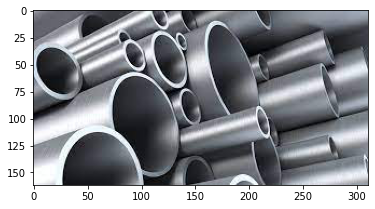

1/1 [==============================] - 1s 1s/step
[[4.7033612e-14 1.4780982e-12 1.0000000e+00 1.3617534e-11]]
1/1 [==============================] - 0s 21ms/step
이사진은 100.00000%확률로, steel로 예측됩니다.


In [8]:
import numpy as np
from keras_preprocessing import image
from skimage import transform
import matplotlib.pyplot as plt
from PIL import Image

#순서대로 item label에 class 이름 list화 시키기
item_label=['brick','cement','steel','wood']
def load(fn):    
      npimg=Image.open(fn)    
      plt.imshow(npimg)    
      plt.show()    
      npimg=np.array(npimg).astype('float')/255    
      npimg=transform.resize(npimg,(150,150,3))    
      npimg=np.expand_dims(npimg,axis=0)    
      return npimg

img=load('/content/drive/MyDrive/data/steel/steel1.jpg')
print(model.predict(img))
predict=item_label[np.argmax(model.predict(img))]
print("이사진은", f"{'%.5f' %(max(max(model.predict(img)))*100)}%확률로, {item_label[np.argmax(model.predict(img))]}로 예측됩니다.")